In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
def read_data(file, m):
    n = int(file.readline().strip())
    X = np.zeros((n, m + 1))
    y = np.zeros(n)
    for i in range(n):
        line = list(map(float, file.readline().strip().split()))
        for j in range(m):
            X[i][j] = line[j]
        X[i][m] = 1
        y[i] = line[m]
    return X, y


def read_dataset(file):
    m = int(file.readline().strip())
    X_train, y_train = read_data(file, m)
    X_test, y_test = read_data(file, m)
    return X_train, y_train, X_test, y_test

In [3]:
def calc_NRMSE(model, X_test, y_test):
    n, *_ = X_test.shape
    y_max = np.max(y_test)
    y_min = np.min(y_test)
    diffs = (model @ np.transpose(X_test)) - y_test
    return math.sqrt(np.dot(diffs, diffs) / n) / (y_max - y_min)

In [4]:
def get_inverse_model(X_train, y_train, tau=0):
    n, m = X_train.shape
    F = X_train
#     F_t = np.transpose(F)
#     to_inv = (F_t @ F) + tau * np.eye(m)
#     model_t = np.linalg.inv(to_inv) @ F_t @ y_train
    model_t = np.linalg.pinv(F) @ y_train
    return model_t.T

In [5]:
def calc_step(w, dots):
    X = np.array(list(map(lambda e: e[0], dots)))
    y = np.array(list(map(lambda e: e[1], dots)))
    n, *_ = dots.shape
    m, *_ = w.shape
    diffs = y - np.transpose(X @ w.T)
    grad = (-2 * diffs) @ X
    scalar_products = np.transpose(X @ grad.T)
    b = np.sum(np.square(scalar_products))
    if b == 0:
        mu = 0
    else:
        a = np.dot(diffs, scalar_products)
        mu = -a / b
    return grad * mu


def get_gradient_model(X_train, y_train, iters_cnt):
    n, m = X_train.shape
    batch_size = min(20, n)
    start_ind = 0
    dots = np.array(list(zip(X_train, y_train)))
    np.random.shuffle(dots)
    w = np.zeros(m)
    for _ in tqdm_notebook(range(iters_cnt)):
        if start_ind >= n:
            np.random.shuffle(dots)
            start_ind = 0
        end_ind = min(n, start_ind + batch_size)
        step = calc_step(w, dots[start_ind:end_ind])
        w -= step
        start_ind = end_ind
    return w

In [6]:
def process_dataset(X_train, y_train, X_test, y_test, solver, solver_param):
    model = solver(X_train, y_train, solver_param)
    return calc_NRMSE(model, X_test, y_test)

In [7]:
def process_file(filenum):
    iter_param = [10 ** k for k in range(1, 8)]
    print('Processing file № {0}'.format(filenum))
    with open('data/{0}.txt'.format(filenum), 'r') as file:
        X_train, y_train, X_test, y_test = read_dataset(file)
        inv_error = process_dataset(X_train, y_train, X_test, y_test, get_inverse_model, 5)
        grad_errors = []
        for iters in iter_param:
            cur_error = process_dataset(X_train, y_train, X_test, y_test, get_gradient_model, iters)
            grad_errors.append(cur_error)
        print(inv_error)
        plt.loglog(iter_param, grad_errors, linestyle='--', marker='o', color='b')
        plt.hlines(inv_error, iter_param[0], iter_param[-1])
        plt.show()

Processing file № 2







4.462929013081919e-06
Processing file № 3







0.0005214562770728551
Processing file № 4







0.0001836266281270796
Processing file № 5








/Users/schrod/prog/ITMO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/schrod/prog/ITMO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


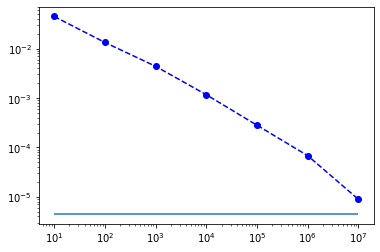

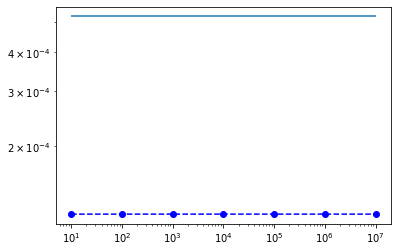

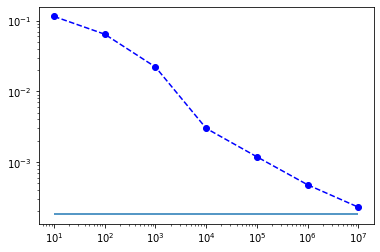

KeyboardInterrupt: 

In [8]:
for i in range(2,7):
    process_file(i)